In this notebook, we analyze our best model and evaluate it on the hold-out test set.

In [1]:
import sys
sys.path.insert(0, "../src/data/")

import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import seaborn as sns

from data_generator import DataGenerator
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, precision_recall_curve
from tensorflow.keras.models import load_model

In [2]:
cores = multiprocessing.cpu_count()

In [3]:
model = load_model("../models/best_model")

In [4]:
ids_train = np.load("../data/processed/any_hemo_split/X_any_hemo_ids_train.npy", allow_pickle=True)
y_train = np.load("../data/processed/any_hemo_split/y_any_hemo_train.npy", allow_pickle=True)
ids_test = np.load("../data/processed/any_hemo_split/X_any_hemo_ids_test.npy", allow_pickle=True)
y_test = np.load("../data/processed/any_hemo_split/y_any_hemo_test.npy", allow_pickle=True)

train_gen = DataGenerator(ids_train, y_train, path="../data/processed/images", batch_size=16)
test_gen = DataGenerator(ids_test, y_test, path="../data/processed/images", batch_size=16)

First we're going to want to plot the specificity-sensitivity curve to determine what the best threshold point might be.

In [5]:
train_prob = model.predict(train_gen, verbose=1, workers=cores)
precisions, recalls, thresholds = precision_recall_curve(y_train, train_prob)

37627/37627 [==============================] - 1834s 49ms/step


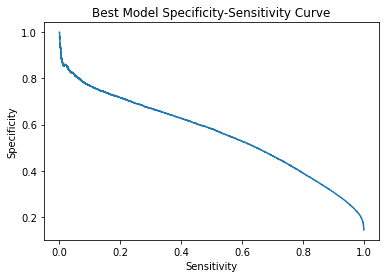

In [10]:
plt.plot(recalls, precisions)
plt.title("Best Model Specificity-Sensitivity Curve")
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.savefig("../models/best_model_precision_recall.png")

Looks like it might be not too far from $0.5$, but let's calculate what yields the best F2 score.

In [7]:
f2s = (5 * precisions * recalls) / ((4 * precisions) + recalls)
threshold = thresholds[np.argmax(f2s)]
f"Best threshold: {threshold} with F2 score of: {f2s[np.argmax(f2s)]}"

'Best threshold: 0.420054167509079 with F2 score of: 0.662600902514359'

Now we can finally test!

In [8]:
y_pred = model.predict(test_gen, verbose=1, workers=cores) > threshold

print("F2 score: ", fbeta_score(y_test, y_pred, 2))
print(classification_report(y_test, y_pred))

9407/9407 [==============================] - 459s 49ms/step
F2 score:  0.6484093169638218
              precision    recall  f1-score   support

           0       0.96      0.76      0.85    128942
           1       0.36      0.81      0.50     21565

    accuracy                           0.77    150507
   macro avg       0.66      0.78      0.67    150507
weighted avg       0.87      0.77      0.80    150507



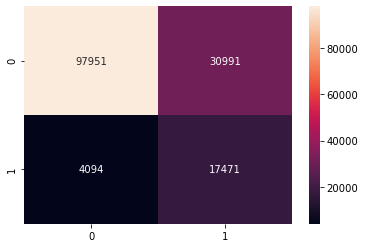

In [9]:
heatmap = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.savefig("../models/best_model_confusion_matrix.png")